In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from rp_ssm import (
    datasets,
    datasets_utils,
    utils,
    dists,
    actions,
    recognition,
    distmaps,
    rpm,
    config,
    training
)

In [2]:
### data
SEED = 0

data = datasets.load_dataset("walker_distract_dynamic", SEED)

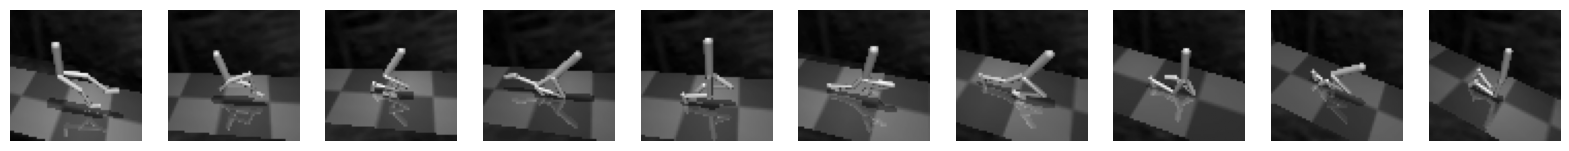

In [6]:
seq_idx = 0
num_imgs = 10

fig, ax = plt.subplots(1, num_imgs, figsize=(2 * num_imgs, 3))
for i in range(num_imgs):
    ax[i].imshow(data.train_obs[0][seq_idx, i*data.train_obs[0].shape[1]//num_imgs], cmap="gray")
    ax[i].set_axis_off()

In [7]:
### prior
latent_dim = 32

prior = dists.ACLGParam(
    opt_params=["Q"],
    A=np.eye(latent_dim),
    Q=np.zeros(latent_dim),
    Q_dist_map=distmaps.MVNDiag(latent_dim),
    action_mapper=actions.ContinuousActionMapper(actions.ActionNetwork(latent_dim=latent_dim, network=recognition.MLP([256, 256]))),
    transition_matrix="multiplicative",
    transition_bias="action_dependent"
)

In [8]:
### recognition
network = recognition.CNN([
    {"features": 16, "kernel_size": (3, 3), "strides": (1, 1), "padding": "SAME"},
    {"features": 16, "kernel_size": (3, 3), "strides": (2, 2), "padding": "SAME"},
    {"features": 32, "kernel_size": (3, 3), "strides": (2, 2), "padding": "SAME"},
    {"features": 32, "kernel_size": (3, 3), "strides": (2, 2), "padding": "SAME"},
    {"features": 32, "kernel_size": (3, 3), "strides": (2, 2), "padding": "SAME"}
])
rec = [
    recognition.RPMRecognition(
        network=network,
        dist_map=distmaps.MVNDiag(latent_dim),
        constant_cov=False
    )
]

In [9]:
### model
model = rpm.RPSSM(
    prior=prior,
    recognition=rec
)

In [10]:
### training config
cfg = config.Config(
    num_iter=50000,
    prior_lr=1e-4,
    rec_lr=(1e-4,),
    act_lr=1e-5,
    batch_size=32,
    jit=True,
    stabilize_A=None, # clip singular values to 1-eps
    seed=SEED
)

In [11]:
### logger
from jax import vmap
def logger(trainer, aux, batch_indices):
    if trainer.itr % 500 == 0:
        posterior = aux["posterior"]
        R2 = utils.krr_r2(posterior.params["means"], data.train_states[batch_indices])[0]
        R2s = getattr(trainer, "R2s", [])
        R2s.append(R2)
        setattr(trainer, "R2s", R2s)
    return {"R2": f"{trainer.R2s[-1]:.2f}"}

In [12]:
### free energy
free_energy = rpm.ConstrainedIVFreeEnergy(model=model, config=cfg)

In [13]:
### initialize and run trainer
trainer = training.Trainer(
    free_energy=free_energy,
    config=cfg,
    logger=logger
)
trainer.fit(data.standardized_data.train_data)

Training with N=400, T=50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [1:35:16<00:00,  8.75it/s, R2=0.74, loss=0.621]


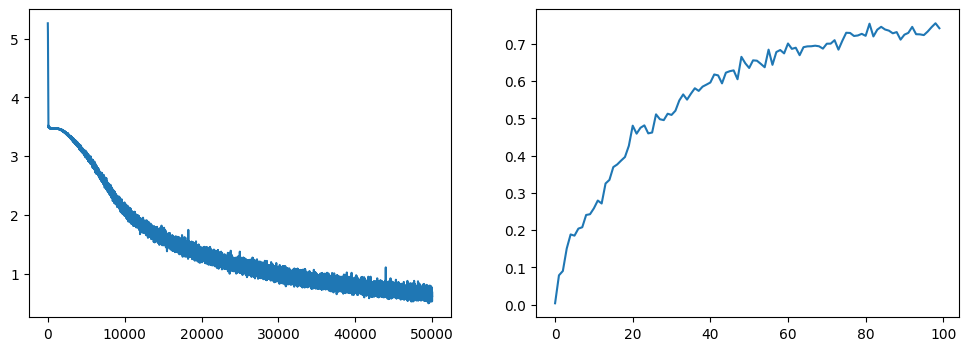

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(trainer.loss_tot)
ax[1].plot(trainer.R2s)